In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import requests
import responses
import requests

In [2]:
import yfinance as yf
sbux = yf.Ticker("NFLX")

In [3]:
sbux.options

('2022-04-14',
 '2022-04-22',
 '2022-04-29',
 '2022-05-06',
 '2022-05-13',
 '2022-05-20',
 '2022-05-27',
 '2022-06-17',
 '2022-07-15',
 '2022-09-16',
 '2022-12-16',
 '2023-01-20',
 '2023-03-17',
 '2023-06-16',
 '2024-01-19')

In [4]:
opt = sbux.option_chain('2024-01-19')

In [5]:
calls = opt.calls

In [6]:
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,NFLX240119C00050000,2022-03-07 20:52:54+00:00,50.0,306.00,317.50,327.00,0.00,0.000000,1.0,9,1.478274,True,REGULAR,USD
1,NFLX240119C00100000,2022-04-05 18:25:44+00:00,100.0,288.50,260.00,269.25,0.00,0.000000,1.0,42,0.757357,True,REGULAR,USD
2,NFLX240119C00150000,2022-04-06 13:56:39+00:00,150.0,235.00,216.50,226.00,0.00,0.000000,1.0,58,0.642582,True,REGULAR,USD
3,NFLX240119C00175000,2022-03-18 18:16:47+00:00,175.0,224.07,196.00,205.15,0.00,0.000000,2.0,0,0.600987,True,REGULAR,USD
4,NFLX240119C00180000,2022-03-18 14:42:16+00:00,180.0,216.00,192.05,201.25,0.00,0.000000,1.0,1,0.594883,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,NFLX240119C01225000,2022-02-17 14:30:09+00:00,1225.0,2.50,0.01,3.20,0.00,0.000000,1.0,1,0.460027,False,REGULAR,USD
99,NFLX240119C01250000,2022-02-23 15:03:03+00:00,1250.0,3.85,0.85,3.35,0.00,0.000000,1.0,3,0.469060,False,REGULAR,USD
100,NFLX240119C01275000,2022-04-08 14:26:17+00:00,1275.0,1.25,0.00,2.85,0.25,25.000000,26.0,38,0.462927,False,REGULAR,USD
101,NFLX240119C01300000,2022-04-06 17:22:12+00:00,1300.0,1.12,0.84,1.59,0.00,0.000000,6.0,342,0.430914,False,REGULAR,USD


In [7]:
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    
    

def implied_vol(opt_value, S, K, T, r, type_='call'):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,6),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")

In [8]:
strike = calls["strike"]
IV = calls["impliedVolatility"]
Spot = calls["lastPrice"]

In [9]:
T = np.arange(0,2,0.0204)
len(T)

99

In [10]:
C = []
for i in range(len(T)):
    C.append(BS_CALL(Spot[i], strike[i], T[i], 0.01, IV[i]))
ivs = []
for i in range(len(T)):
    iv = implied_vol(C[i], Spot[i], strike[i], 3, 3.5)
    ivs.append(iv)

C:\Users\affan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


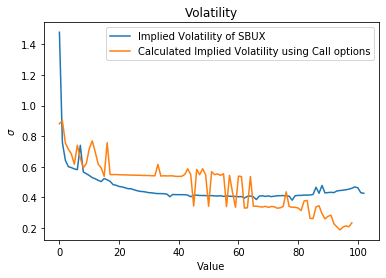

In [11]:
plt.plot(IV,label='Implied Volatility of NFLX')
plt.plot(ivs,label='Calculated Implied Volatility using Call options')
plt.xlabel('Value')
plt.ylabel('$\sigma$')
plt.title('Volatility')
plt.legend()
plt.show()

In [12]:
Civ = []
for i in range(len(T)):
    Civ.append(BS_CALL(Spot[i], strike[i], T[i], 3.5, ivs[i]))

C:\Users\affan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


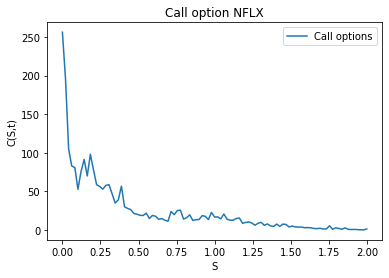

In [15]:
plt.plot(T,Civ,label='Call options')
plt.xlabel('S')
plt.ylabel('C(S,t)')
plt.title('Call option NFLX')
plt.legend()